## Customer Personality Analysis

### Necessary Imports

In [1]:
from typing import Tuple, List, Callable, Sequence
from datetime import datetime, date, timedelta
from enum import Enum, auto

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Helper Constants

In [2]:
READ_CSV: Callable[[], pd.DataFrame] = lambda: pd.read_csv('./marketing_campaign.csv', sep='\t')

# Autocomplete helper
class DataColumn:
    ID = 'ID'
    YEAR_BIRTH = 'Year_Birth'
    EDUCATION = 'Education'
    MARITAL_STATUS = 'Marital_Status'
    INCOME = 'Income'
    KIDHOME = 'Kidhome'
    TEENHOME = 'Teenhome'
    DT_CUSTOMER = 'Dt_Customer'
    RECENCY = 'Recency'
    MNTWINES = 'MntWines'
    MNTFRUITS = 'MntFruits'
    MNTMEATPRODUCTS = 'MntMeatProducts'
    MNTFISHPRODUCTS = 'MntFishProducts'
    MNTSWEETPRODUCTS = 'MntSweetProducts'
    MNTGOLDPRODS = 'MntGoldProds'
    NUMDEALSPURCHASES = 'NumDealsPurchases'
    NUMWEBPURCHASES = 'NumWebPurchases'    
    NUMCATALOGPURCHASES = 'NumCatalogPurchases'
    NUMSTOREPURCHASES = 'NumStorePurchases'
    NUMWEBVISITSMONTH = 'NumWebVisitsMonth'
    ACCEPTEDCMP1 = 'AcceptedCmp1'
    ACCEPTEDCMP2 = 'AcceptedCmp2'
    ACCEPTEDCMP3 = 'AcceptedCmp3'
    ACCEPTEDCMP4 = 'AcceptedCmp4'
    ACCEPTEDCMP5 = 'AcceptedCmp5'
    COMPLAIN = 'Complain'
    RESPONSE = 'Response'
    Z_COSTCONTACT = 'Z_CostContact'
    Z_REVENUE = 'Z_Revenue'
    CUSTOMER_FOR = 'Customer_For'
    AGE = 'Age'
    SPENT = 'Spent'
    LIVING_WITH = 'Living_With'
    CHILDREN_TOTAL = 'Children_Total'
    FAMILY_SIZE = 'Family_Size'
    AGE_GROUP = 'Age_Group'
    IS_PARENT = 'Is_Parent'

### **Q1**: Initial Dataset preprocessing & cleaning

We read the dataset to observe its shape:

In [3]:
dataDf = READ_CSV()
dataDf.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


We initially search for columns with missing values:

In [4]:
def countMissingByColumn(df: pd.DataFrame):
    temp = df.isnull().sum().sort_values(ascending=False)
    missingDf = pd.DataFrame(temp.loc[temp > 0])
    missingDf.columns = ['Missing']
    return missingDf

countMissingByColumn(dataDf)

,Missing
Income,24


We can see there are missing `Income` values in some rows. Let's examine them in detail:

In [5]:
dataDf.loc[dataDf[DataColumn.INCOME].isna()].head(n=8)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
10,1994,1983,Graduation,Married,NaN,1,0,15-11-2013,11,5,...,7,0,0,0,0,0,0,3,11,0
27,5255,1986,Graduation,Single,NaN,1,0,20-02-2013,19,5,...,1,0,0,0,0,0,0,3,11,0
43,7281,1959,PhD,Single,NaN,0,0,05-11-2013,80,81,...,2,0,0,0,0,0,0,3,11,0
48,7244,1951,Graduation,Single,NaN,2,1,01-01-2014,96,48,...,6,0,0,0,0,0,0,3,11,0
58,8557,1982,Graduation,Single,NaN,1,0,17-06-2013,57,11,...,6,0,0,0,0,0,0,3,11,0
71,10629,1973,2n Cycle,Married,NaN,1,0,14-09-2012,25,25,...,8,0,0,0,0,0,0,3,11,0
90,8996,1957,PhD,Married,NaN,2,1,19-11-2012,4,230,...,9,0,0,0,0,0,0,3,11,0
91,9235,1957,Graduation,Single,NaN,1,1,27-05-2014,45,7,...,7,0,0,0,0,0,0,3,11,0


These rows actually have useful data, excluding the `Income` value, therefore we choose to keep them.\
We can fill the missing `Income` values with the **mean** dataset `Income` value.

In [6]:
dataDf[DataColumn.INCOME].fillna(dataDf[DataColumn.INCOME].mean(), inplace=True )

In [7]:
# dataDf.loc[dataDf['ID'] == 1994]

There are no longer missing values, in any column:

In [8]:
countMissingByColumn(dataDf)

,Missing


We notice certain columns have non-numerical values:

In [9]:
dataDf.select_dtypes(include='object').head()

,Education,Marital_Status,Dt_Customer
0,Graduation,Single,04-09-2012
1,Graduation,Single,08-03-2014
2,Graduation,Together,21-08-2013
3,Graduation,Together,10-02-2014
4,PhD,Married,19-01-2014


We convert `Dt_Customer` string values (dates) to `datetime` objects.\
`Education` & `Marital_Status` will be processed in Q7 using **one hot encoding**.

In [10]:
dataDf[DataColumn.DT_CUSTOMER] = dataDf[DataColumn.DT_CUSTOMER].apply(lambda d: datetime.strptime(d, "%d-%m-%Y"))
dataDf[DataColumn.DT_CUSTOMER].head()

0   2012-09-04
1   2014-03-08
2   2013-08-21
3   2014-02-10
4   2014-01-19
Name: Dt_Customer, dtype: datetime64[ns]

### **Q2**: Simplyfying `Marital_Status` values

Now, as requested, we observe the unique values in the `Education` column:

In [11]:
dataDf[DataColumn.EDUCATION].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

As well as the values in the `Marital_Status` column:

In [12]:
dataDf[DataColumn.MARITAL_STATUS].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

And replace `Marital_Status` values `'Alone'`, `'Absurd'` and `'YOLO'` with `'Single'`

In [13]:
# A helper enum class, which will be used below as well as afterwards
class TitlecasedStrEnum(Enum):
    def _generate_next_value_(name: str, *_):
        return str.title(name)

class MaritalStatus(str, TitlecasedStrEnum):
    SINGLE = auto()
    TOGETHER = auto()
    MARRIED = auto()
    DIVORCED = auto()
    WIDOW = auto()

maritalStatusToReplace = ['Alone', 'Absurd', 'YOLO']

dataDf.replace(to_replace=maritalStatusToReplace, value=MaritalStatus.SINGLE, inplace=True)
dataDf[DataColumn.MARITAL_STATUS].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow'], dtype=object)

Below we can see the number of customers assigned to each `Marital_Status` and `Education` category:

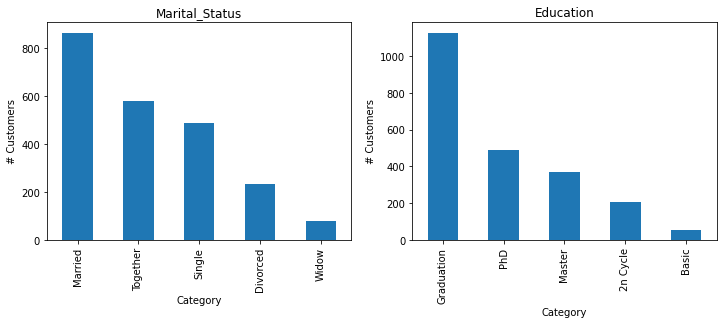

In [14]:
cols = (DataColumn.MARITAL_STATUS, DataColumn.EDUCATION)
fig, axes = plt.subplots(1, len(cols), figsize=(len(cols)*6, 4))

for i, (ax, col) in enumerate( zip(axes, cols) ):
    ax.set_title(col)
    ax.set_xlabel('Category')
    ax.set_ylabel('# Customers')
    _ = dataDf[col].value_counts().plot(kind="bar", ax=ax).plot()

We also notice that all `Z_CostContact` and `Z_Revenue` cells have the same values:

In [15]:
dataDf[DataColumn.Z_COSTCONTACT].unique(), dataDf[DataColumn.Z_REVENUE].unique()

(array([3]), array([11]))

Therefore we can drop them entirely:

In [16]:
dataDf.drop(columns=[DataColumn.Z_COSTCONTACT, DataColumn.Z_REVENUE], inplace=True)

### **Q3**: Generating new features

**A.** Adding a new `Customer_For` feature using the `Dt_Customer` and `Recency` features

In [17]:
def extractCustomerTime(args: Tuple[int, datetime]):
    daysSince, startDate = args
    recencyDate = datetime.now() - timedelta(days=daysSince)
    return (recencyDate - startDate).days

dataDf[DataColumn.CUSTOMER_FOR] = dataDf[[DataColumn.RECENCY, DataColumn.DT_CUSTOMER]].apply(
    lambda args: extractCustomerTime(tuple(args)),
    axis=1
)

**B.** Adding a new `Age` column based on `Year_Birth` column:

In [18]:
dataDf[DataColumn.AGE] = date.today().year - dataDf[DataColumn.YEAR_BIRTH]

**C.** Creating a new `Spent` column, which is the sum of `MntWines`, `MntFruits`, `MntMeatProducts`, `MntFishProducts`, `MntSweetProducts` & `MntGoldProds` columns

In [19]:
mntCols = [
    DataColumn.MNTWINES,
    DataColumn.MNTFRUITS,
    DataColumn.MNTMEATPRODUCTS,
    DataColumn.MNTFISHPRODUCTS,
    DataColumn.MNTSWEETPRODUCTS,
    DataColumn.MNTGOLDPRODS
]
dataDf[DataColumn.SPENT] = dataDf[mntCols].sum(axis=1)

**D.** Adding a new `Children_Total` column, which is the sum of `Kidhome` and `Teenhome` columns

In [20]:
dataDf[DataColumn.CHILDREN_TOTAL] = dataDf[[DataColumn.KIDHOME, DataColumn.TEENHOME]].sum(axis=1)

**F.** Generating a new `Is_Parent` feature, based on the `Children_Total` feature.

In [21]:
dataDf[DataColumn.IS_PARENT] = dataDf[DataColumn.CHILDREN_TOTAL].apply(lambda total: int(total > 0))

**G.** Generating a new `Living_With` feature, based on the `Marital_Status` feature.

In [22]:
class LivingWithStatus(str, TitlecasedStrEnum):
    PARTNER = auto()
    ALONE = auto()

def mapMaritalStatusToLivingWith(ms: MaritalStatus):
    if ms == MaritalStatus.MARRIED or ms == MaritalStatus.TOGETHER:
        return LivingWithStatus.PARTNER.value
    return LivingWithStatus.ALONE.value

dataDf[DataColumn.LIVING_WITH] = dataDf[DataColumn.MARITAL_STATUS].apply(mapMaritalStatusToLivingWith)
dataDf[[DataColumn.LIVING_WITH, DataColumn.MARITAL_STATUS]].head(n=8)

,Living_With,Marital_Status
0,Alone,Single
1,Alone,Single
2,Partner,Together
3,Partner,Together
4,Partner,Married
5,Partner,Together
6,Alone,Divorced
7,Partner,Married


**E.** Generating a new `Family_Size` feature, based on `Children_Total` & `Living_With` (**Q3.G**) features.

In [23]:
def findFamilySize(args: Tuple[int, LivingWithStatus]):
    childrenTotal, livingWith = args
    return childrenTotal + int(livingWith == LivingWithStatus.PARTNER) + 1

dataDf[DataColumn.FAMILY_SIZE] = dataDf[[DataColumn.CHILDREN_TOTAL, DataColumn.LIVING_WITH]].apply(
    lambda args: findFamilySize(tuple(args)),
    axis=1
)
dataDf[[DataColumn.FAMILY_SIZE, DataColumn.LIVING_WITH, DataColumn.CHILDREN_TOTAL]].head(n=8)

,Family_Size,Living_With,Children_Total
0,1,Alone,0
1,3,Alone,2
2,2,Partner,0
3,3,Partner,1
4,3,Partner,1
5,3,Partner,1
6,2,Alone,1
7,3,Partner,1


**H.** Generating a new `Age_Group` column, based on the `Age` column.

In [24]:
class AgeGroups:
    groupLimits = [
        21,
        30,
        40,
        50,
        60,
        70,
        80
    ]
    assert groupLimits == sorted(groupLimits)

    @staticmethod
    def getAgeGroupStrings():
        groups: List[str] = []
        for i, gl in enumerate(AgeGroups.groupLimits):
            if i == 0:
                groups.append(f'<{gl}')
                if len(AgeGroups.groupLimits) > 1:
                    groups.append(f'{gl}-{AgeGroups.groupLimits[i + 1]}')
                continue

            if i < len(AgeGroups.groupLimits) - 1:
                groups.append(f'{gl + 1}-{AgeGroups.groupLimits[i + 1]}')
        
        groups.append(f'>{AgeGroups.groupLimits[-1]}')
        return groups

    @staticmethod
    def mapAgeToAgeGroup(age: int):
        for i, gl in enumerate(AgeGroups.groupLimits):
            if age < gl:
                if i > 0:
                    return f'{AgeGroups.groupLimits[i-1] + 1}-{gl}'
                else:
                    return f'<{gl}'
        
        return f'>{AgeGroups.groupLimits[-1]}'

dataDf[DataColumn.AGE_GROUP] = dataDf[DataColumn.AGE].apply(AgeGroups.mapAgeToAgeGroup)
dataDf[[DataColumn.AGE_GROUP, DataColumn.AGE]].head(n=8)

,Age_Group,Age
0,61-70,66
1,61-70,69
2,51-60,58
3,31-40,39
4,41-50,42
5,51-60,56
6,51-60,52
7,31-40,38


In [25]:
# AgeGroups.getAgeGroupStrings()

### **Q4**: Detecting & Removing outlier values

Before removing any rows, the shape of the `DataFrame` is:

In [26]:
dataDf.shape

(2240, 35)

After examining the box plots for each feature, we decided to remove rows with outlier `Age`, `Spent` & `Income` values.

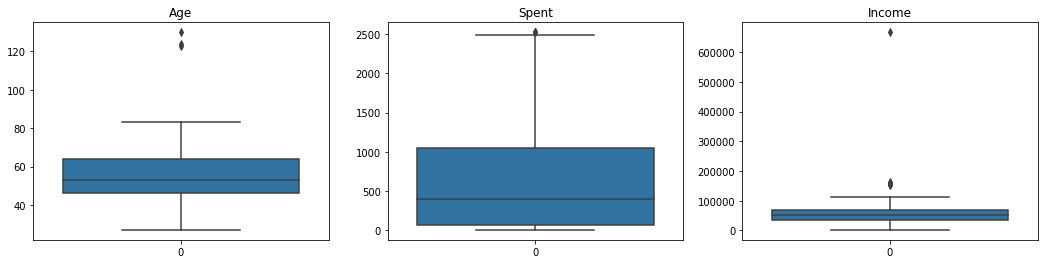

In [27]:
outlierCols = (
    DataColumn.AGE,
    DataColumn.SPENT,
    DataColumn.INCOME
)

def boxPlotCols(df: pd.DataFrame, cols: Sequence[str]):
    _, axes = plt.subplots(1, len(cols), figsize=(len(cols)*6, 4))
    for i, col in enumerate(cols):
        axes[i].set_title(col)
        sns.boxplot(data=df[col], ax=axes[i])
        
boxPlotCols(dataDf, outlierCols)

We eliminate the outliers using the IQR (Inter Quartile Range) method.
See also:
- https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/
- https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097

In [28]:
def removeColumnOutliers(df: pd.DataFrame, col: str) -> pd.DataFrame:
    q1 = np.percentile(df[col], q=25, interpolation='midpoint')
    q3 = np.percentile(df[col], q=75, interpolation='midpoint')
    iqr = q3 - q1

    #lowerLimit = max(1, q3 - 1.5 * iqr)
    lowerLimit = q3 - 1.5 * iqr
    upperLimit = q3 + 1.5 * iqr

    df = df[df[col] <= upperLimit]
    return df[df[col] >= lowerLimit]

for col in outlierCols:
    dataDf = removeColumnOutliers(dataDf, col)

After removing outlier rows, the shape of the `DataFrame` is:

In [29]:
dataDf.shape

(1975, 35)

We can also verify the effect of the outliers removal by revisiting the boxplots of the target columns:

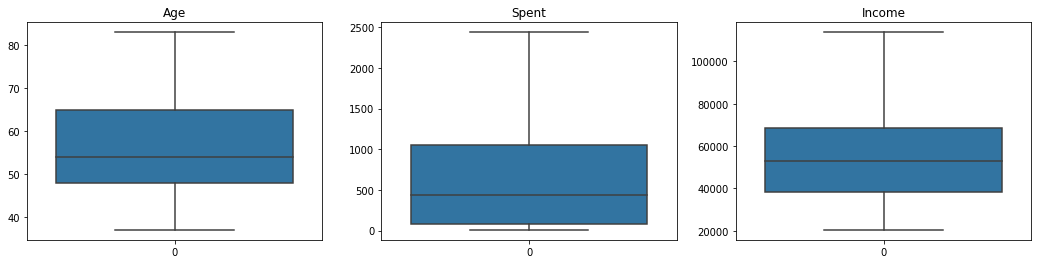

In [30]:
boxPlotCols(dataDf, outlierCols)

**Q5.** Presenting the relationships between (numeric) features using a **heatmap**.\
We exclude the following features:
- `ID`, since it is not valuable information
- `Year_Birth`, since it is represented by `Age`
- `Is_Parent`, `Kidhome` and `Teenhome`, since they are represented by `Children_Total`

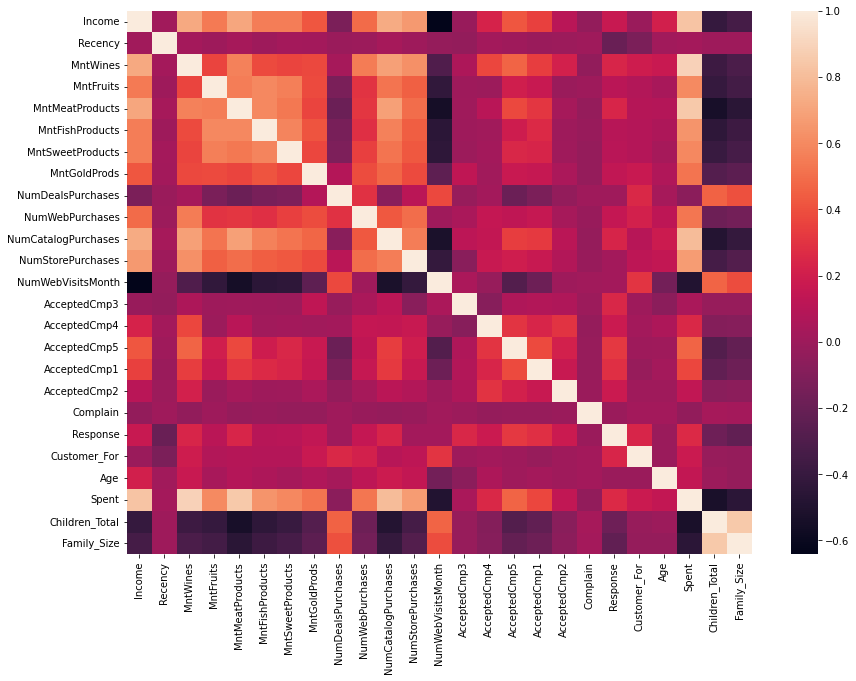

In [34]:
excludeCols = [
    DataColumn.ID,
    DataColumn.YEAR_BIRTH,
    DataColumn.KIDHOME,
    DataColumn.TEENHOME,
    DataColumn.IS_PARENT,
    
    # DataColumn.ACCEPTEDCMP1,
    # DataColumn.ACCEPTEDCMP2,
    # DataColumn.ACCEPTEDCMP3,
    # DataColumn.ACCEPTEDCMP4,
    # DataColumn.ACCEPTEDCMP5,
    # DataColumn.MNTFISHPRODUCTS,
    # DataColumn.MNTFRUITS,
    # DataColumn.MNTGOLDPRODS,
    # DataColumn.MNTMEATPRODUCTS,
    # DataColumn.MNTSWEETPRODUCTS,
    # DataColumn.MNTWINES,
    # DataColumn.NUMCATALOGPURCHASES,
    # DataColumn.NUMDEALSPURCHASES,
    # DataColumn.NUMWEBPURCHASES,
    # DataColumn.NUMSTOREPURCHASES,
    # DataColumn.NUMWEBVISITSMONTH,
    # DataColumn.COMPLAIN,
    # DataColumn.RESPONSE
]

dfView = dataDf.select_dtypes(include=['int64', 'float64']).drop(excludeCols, axis=1)
_, axes = plt.subplots(1, 1, figsize=(14,10))
_ = sns.heatmap(dfView.corr(), ax=axes)